# Welcome!
In this notebook, we will train a neural network to play the Snake game using the Neuroevolution through Augmenting Toplogies (NEAT) algorithm. NEAT is a genetic algorithm that evolves populations of neural networks by altering their weights, biases and topology by crossing over and mutating the neural networks. The best networks get to live and reproduce, producing a more fit offsping. The specific settings that the NEAT algorithm uses can be altered in the 'config-neat' file. For more information on how NEAT works, you can check out the original paper by Stanley and Miikkulainen [here](http://nn.cs.utexas.edu/downloads/papers/stanley.ec02.pdf). 

We want to investigate how the information the Snake receives about its environment, as well how it is able to manipulate its environment affect its learning. To do this, we will guide you through various experiments with different input and outputs the network receives. The source code for the project can be found within the 'snake_game.py' file.

In [1]:
# !pip install neat-python
# !pip install pygame

import os
import numpy as np
import matplotlib.pyplot as plt
import neat
from snake_game import *

#Set the local directory
local_dir = os.getcwd()
neat_config_path = os.path.join(local_dir, Paths.NEAT_CONFIG_PATH)
config_path = os.path.join(local_dir, Paths.CONFIG_PATH)

# Load neat configuration into a NEAT object.
neat_config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        neat_config_path)

use_obstacles = True # Set to True to use obstacles for all Experiments and create plots for them (although we will investigate obstacles in Investigation 3 seperately as well)xw

## Tutorial
Before we start the experiments, it is useful to explain how the code works. We will first create an instance of the SnakeGame class and run the game for a few steps to see how it works. For now, we will use a simple game without any obstacles. The snake has information on its distance to the wall, distance to it's nearest body segment, and it's distance to the apple in all cardinal directions (up, down, left, right). The snake can also move in any of these directions. We will run the NEAT algorithm 5 times for 30 generations each. From these we obtain a list with the 'statistics' of each run, from which we can extract general information of the run using the [`StatisticsReporter`](https://neat-python.readthedocs.io/en/latest/_modules/statistics.html) module of neat-python.

In [2]:
if use_obstacles:
    input_features = ['relative_wall', 'relative_body','relative_apple', 'relative_obstacle']
else:
    input_features = ['relative_wall', 'relative_body','relative_apple']
    
SnakeV0 = SnakeGame(input_features= input_features,
                          input_frame_of_reference= 'NSEW', #Input frame of reference, either 'NSEW' or 'SNAKE'
                          output_frame_of_reference= 'NSEW', #Output frame of reference, either 'NSEW' or 'SNAKE'
                          use_obstacles= use_obstacles, #Whether to use obstacles in the game
                          n_runs = 5, #Number of runs for the NEAT algorithm
                          n_generations = 30, #Number of generations for the NEAT algorithm
                          time_interval= 200, #Time interval for Pygame to update the screen (in ms)
                          checkpoint_interval= 10) #How often to save the best genome (every n generations)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV0.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV0.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV0
SnakeV0_stats = SnakeV0.run_NEAT_repeated(neat_config_path)

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV0_stats', SnakeV0_stats)

# Get the best genome of all generations for all runs
SnakeV0_winners = [stats.best_genome() for stats in SnakeV0_stats]

# Get the best genome of all generations over all runs
best_run_idx = np.argmax([winner.fitness for winner in SnakeV0_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV0_winners[best_run_idx].fitness}")

{'num_inputs': '16', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9
Saving checkpoint to checkpoints//run0/population-19
Saving checkpoint to checkpoints//run0/population-29
Run 0 completed, best fitness: 2.6
Running NEAT algorithm, run 1
Saving checkpoint to checkpoints//run1/population-9
Saving checkpoint to checkpoints//run1/population-19
Saving checkpoint to checkpoints//run1/population-29
Run 1 completed, best fitness: 2.8
Running NEAT algorithm, run 2
Saving checkpoint to checkpoints//run2/population-9
Saving checkpoint to checkpoints//run2/population-19
Saving checkpoint to checkpoints//run2/population-29
Run 2 completed, best fitness: 2.6
Running NEAT algorithm, run 3
Saving checkpoint to checkpoints//run3/population-9
Saving checkpoint to checkpoints//run3/population-19
Saving checkpoint to checkpoints//run3/population-29
Run 3 completed, best fitness: 3.9
Running NEAT algorithm, run 4
Saving checkpoint to checkpoints//run

### Visualize Results
For any run, it's possible to visualize the evolution of the fitness over time, as shown below:

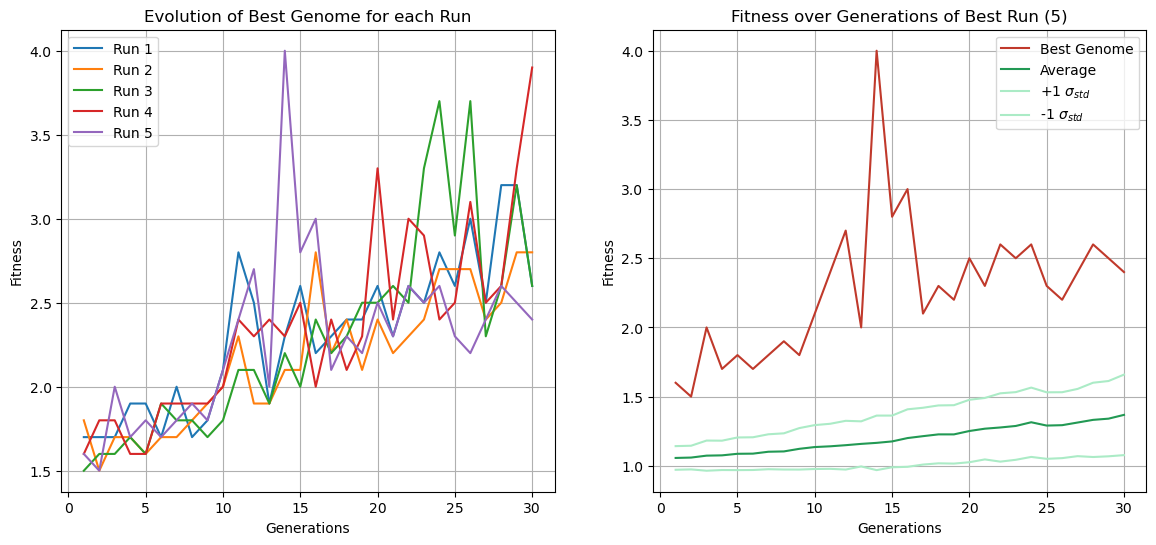

In [3]:
#Get statistics from the best run
generations = range(1, SnakeV0.N_GENERATIONS + 1)
winner_stats = SnakeV0_stats[best_run_idx]
best_fitnesses = [g.fitness for g in winner_stats.most_fit_genomes]
avg_fitnesses = np.array(winner_stats.get_fitness_mean())
stdev_fitnesses = np.array(winner_stats.get_fitness_stdev())

# Plot the best run statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get statistics from all runs
best_genomes = [[g for g in stats.most_fit_genomes] for stats in SnakeV0_stats]

# Plot the best genome of each run
for i, genome in enumerate(best_genomes):
    fitnesses = [g.fitness for g in genome]
    ax1.plot(generations, fitnesses, label=f"Run {i + 1}")

ax1.set_title("Evolution of Best Genome for each Run")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness")
ax1.grid()
ax1.legend(loc="best")

ax2.plot(generations, best_fitnesses, color='#c0392b', label="Best Genome")
ax2.plot(generations, avg_fitnesses, color='#229954', label="Average")
ax2.plot(generations, avg_fitnesses + stdev_fitnesses, color='#abebc6', label="+1 $\sigma_{std}$")
ax2.plot(generations, avg_fitnesses - stdev_fitnesses, color='#abebc6', label="-1 $\sigma_{std}$")

ax2.set_title(f"Fitness over Generations of Best Run ({best_run_idx + 1})")
ax2.set_xlabel("Generations")
ax2.set_ylabel("Fitness")
ax2.grid()
ax2.legend(loc="best")


plt.show()

### Simulate the best genome
It is also possible to visualize the best genome playing the Snake game at any point during the evolution process. This can be useful to understand how the snake is learning and to analyse gradual improvements or sudden improvements in fitness. Let's see how the best genome (of the best run) at generation 15 compares to the best genome at generation 30.

*Note: Sometimes it is required to run the cell below twice to see the game render correctly*

In [4]:
generation_nr_1 = 15 
generation_nr_2 = -1 #select the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV0_stats[best_run_idx].most_fit_genomes]

# genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV0.test_winner(genome_1, neat_config_path)
# SnakeV0.test_winner(genome_2, neat_config_path)

## Experiment 1: Frame of Reference

Here we investigate the importance of the frame of reference our snake uses. One might have already noticed, that having outputs for each of the 4 directions is not very useful. This is because one output will always result in death (the snake running back in its own body). Instead, we can have 3 outputs: one for turning left, one for turning right and one for moving straight. We can set `output_frame_of_reference = 'SNAKE'` to use this frame of reference and compare performance.

In [5]:
SnakeV1 = SnakeGame(input_features= input_features,
                          input_frame_of_reference= 'NSEW', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV1.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV1.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV1
SnakeV1_stats = SnakeV1.run_NEAT_repeated(neat_config_path)
SnakeV1_winners = [stats.best_genome() for stats in SnakeV1_stats] #List of best genome for each run

best_run_idx = np.argmax([winner.fitness for winner in SnakeV1_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV1_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV1_winners', SnakeV1_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV1_stats', SnakeV1_stats)

{'num_inputs': '16', 'num_outputs': '3'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9
Saving checkpoint to checkpoints//run0/population-19
Saving checkpoint to checkpoints//run0/population-29
Run 0 completed, best fitness: 1.6
Running NEAT algorithm, run 1
Saving checkpoint to checkpoints//run1/population-9
Saving checkpoint to checkpoints//run1/population-19
Saving checkpoint to checkpoints//run1/population-29
Run 1 completed, best fitness: 2.0
Running NEAT algorithm, run 2
Saving checkpoint to checkpoints//run2/population-9
Saving checkpoint to checkpoints//run2/population-19
Saving checkpoint to checkpoints//run2/population-29
Run 2 completed, best fitness: 1.6
Running NEAT algorithm, run 3
Saving checkpoint to checkpoints//run3/population-9
Saving checkpoint to checkpoints//run3/population-19
Saving checkpoint to checkpoints//run3/population-29
Run 3 completed, best fitness: 1.6
Running NEAT algorithm, run 4
Saving checkpoint to checkpoints//run

Note: The computation time now is a lot longer. This is because the snake cannot move back into itself, causing the average snake to live longer (although not necessarily doing anything useful like eating apples). You can check this yourself by setting 'time_to_eat_apple' to half the value, and see that the computation time is halved.

### Compare the two output frames of reference

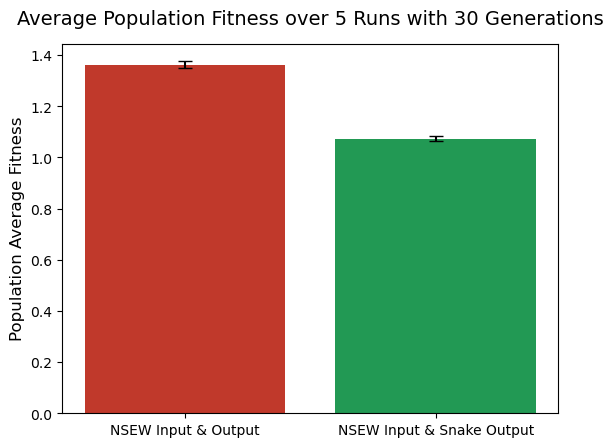

In [6]:
# Calculate average fitness and standard deviation of the WHOLE POPULATION over all runs
average_fitness_V0 = np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV0_stats])
std_fitness_V0 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV0_stats])

average_fitness_V1= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV1_stats])
std_fitness_V1 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV1_stats])

# Data to plot
fitness_means = [average_fitness_V0, average_fitness_V1]
fitness_stds = [std_fitness_V0, std_fitness_V1]
labels = ['NSEW Input & Output', 'NSEW Input & Snake Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954'])
ax.set_ylabel('Population Average Fitness', fontsize=12)
ax.set_title(f'Average Population Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations', fontsize=14, y = 1.03)

# Show the plot
plt.show()

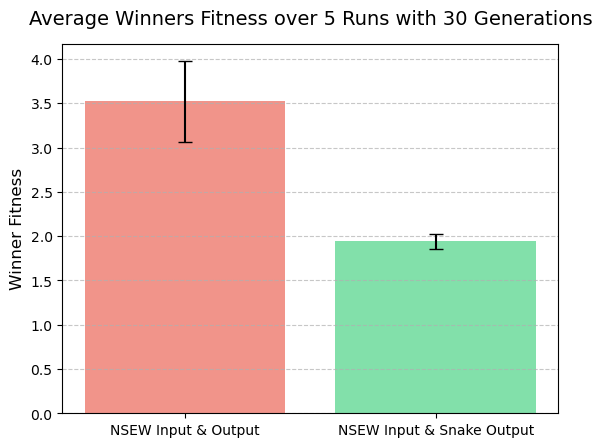

In [7]:
# Calculate the average fitness and standard deviation of the WINNERS ONLY over all runs
best_fitness_V0 = np.mean([g.fitness for g in SnakeV0_winners])
best_std_V0 = np.std([g.fitness for g in SnakeV0_winners])

best_fitness_V1 = np.mean([g.fitness for g in SnakeV1_winners])
best_std_V1 = np.std([g.fitness for g in SnakeV1_winners])

# Data to plot
fitness_means = [best_fitness_V0, best_fitness_V1]
fitness_stds = [best_std_V0, best_std_V1]
labels = ['NSEW Input & Output', 'NSEW Input & Snake Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#f1948a', '#82e0aa'])
ax.set_ylabel('Winner Fitness', fontsize=12)
ax.set_title(f'Average Winners Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations', fontsize=14, y = 1.03)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

We could say that that result is not that great. Although it might seem we made the network's job easier by reducing the number of outputs and not being able to run in itself, we gave it a much harder task: learn a coordinate transformation from the cardinal directions to the new frame of reference. This is a much harder task than simply learning to avoid running into itself.

To fix this, we can define the inputs of the network in the new frame of reference. This way, the network will not have to learn the transformation. We can set `input_frame_of_reference = 'SNAKE'` to use this frame of reference and compare performance.

In [8]:
SnakeV2 = SnakeGame(input_features= input_features,
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV2.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV2.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV2
SnakeV2_stats= SnakeV2.run_NEAT_repeated(neat_config_path)
SnakeV2_winners = [stats.best_genome() for stats in SnakeV2_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV2_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV2_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV2_winners', SnakeV2_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV2_stats', SnakeV2_stats)

{'num_inputs': '12', 'num_outputs': '3'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9
Saving checkpoint to checkpoints//run0/population-19
Saving checkpoint to checkpoints//run0/population-29
Run 0 completed, best fitness: 13.8
Running NEAT algorithm, run 1
Saving checkpoint to checkpoints//run1/population-9
Saving checkpoint to checkpoints//run1/population-19
Saving checkpoint to checkpoints//run1/population-29
Run 1 completed, best fitness: 14.0
Running NEAT algorithm, run 2
Saving checkpoint to checkpoints//run2/population-9
Saving checkpoint to checkpoints//run2/population-19
Saving checkpoint to checkpoints//run2/population-29
Run 2 completed, best fitness: 12.0
Running NEAT algorithm, run 3
Saving checkpoint to checkpoints//run3/population-9
Saving checkpoint to checkpoints//run3/population-19
Saving checkpoint to checkpoints//run3/population-29
Run 3 completed, best fitness: 11.4
Running NEAT algorithm, run 4
Saving checkpoint to checkpoints/

### Add new result to the plot

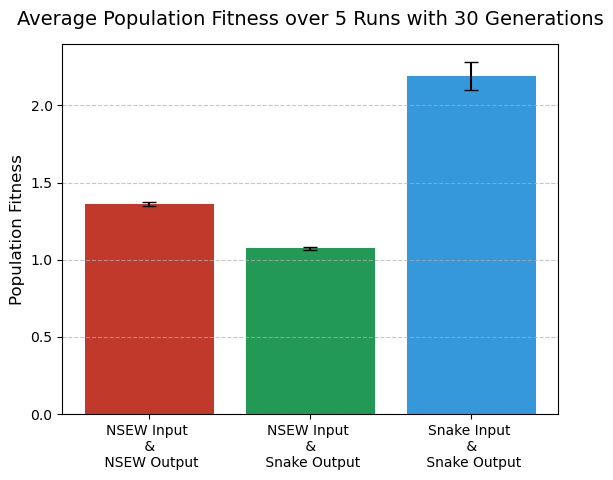

In [9]:
# Calculate average fitness and standard deviation of the WHOLE POPULATION over all runs
average_fitness_V2= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV2_stats])
std_fitness_V2 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV2_stats])

# Data to plot
fitness_means = [average_fitness_V0, average_fitness_V1, average_fitness_V2]
fitness_stds = [std_fitness_V0, std_fitness_V1, std_fitness_V2]
labels = ['NSEW Input \n & \n NSEW Output', 'NSEW Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954', '#3498db'])
ax.set_ylabel('Population Fitness', fontsize=12)
ax.set_title(f'Average Population Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations', fontsize=14, y = 1.03)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

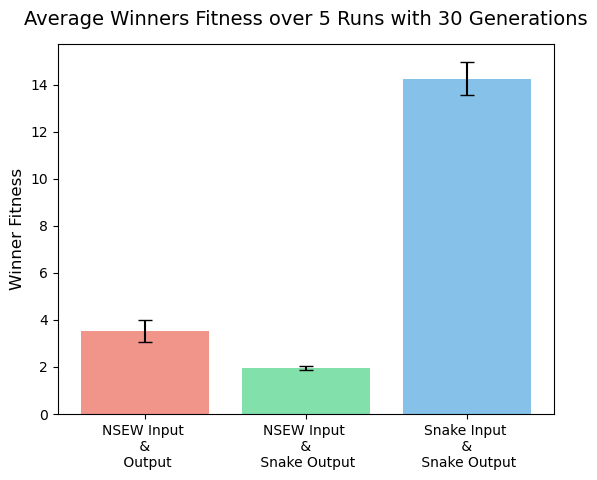

In [10]:
# Calculate the average fitness and standard deviation of the WINNERS ONLY over all runs
best_fitness_V2 = np.mean([g.fitness for g in SnakeV2_winners])
best_std_V2 = np.std([g.fitness for g in SnakeV2_winners])

# Data to plot
fitness_means = [best_fitness_V0, best_fitness_V1, best_fitness_V2]
fitness_stds = [best_std_V0, best_std_V1, best_std_V2]
labels = ['NSEW Input \n & \n Output', 'NSEW Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#f1948a', '#82e0aa', '#85c1e9'])
ax.set_ylabel('Winner Fitness', fontsize=12)
ax.set_title(f'Average Winners Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations', fontsize=14, y = 1.03)

# Show the plot
plt.show()

### Simulate the results

In [11]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV2_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV0.test_winner(genome_1, neat_config_path)
# SnakeV0.test_winner(genome_2, neat_config_path)

### Reversed Situation

For sake of curiosity, we can also test the performance of the network in the reversed situation, where the inputs are in the new frame of reference and the outputs are in the old frame of reference.

{'num_inputs': '12', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9
Saving checkpoint to checkpoints//run0/population-19
Saving checkpoint to checkpoints//run0/population-29
Run 0 completed, best fitness: 1.4
Running NEAT algorithm, run 1
Saving checkpoint to checkpoints//run1/population-9
Saving checkpoint to checkpoints//run1/population-19
Saving checkpoint to checkpoints//run1/population-29
Run 1 completed, best fitness: 1.4
Running NEAT algorithm, run 2
Saving checkpoint to checkpoints//run2/population-9
Saving checkpoint to checkpoints//run2/population-19
Saving checkpoint to checkpoints//run2/population-29
Run 2 completed, best fitness: 1.3
Running NEAT algorithm, run 3
Saving checkpoint to checkpoints//run3/population-9
Saving checkpoint to checkpoints//run3/population-19
Saving checkpoint to checkpoints//run3/population-29
Run 3 completed, best fitness: 1.4
Running NEAT algorithm, run 4
Saving checkpoint to checkpoints//run

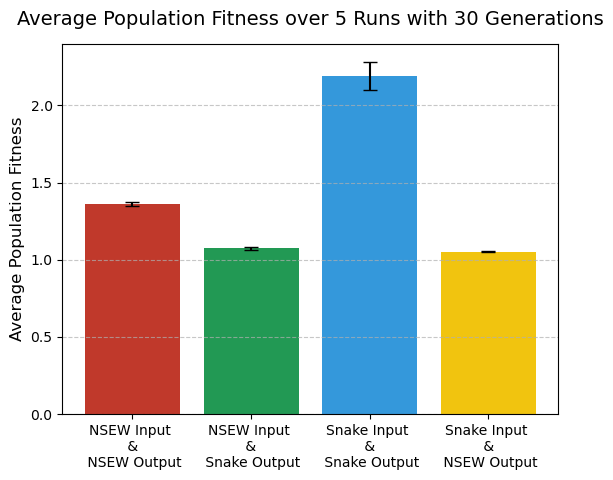

In [12]:
SnakeV3 = SnakeGame(input_features= input_features,
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'NSEW', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV3.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV3.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV3
SnakeV3_stats = SnakeV3.run_NEAT_repeated(neat_config_path)
SnakeV3_winners = [stats.best_genome() for stats in SnakeV3_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV3_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV3_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV3_winners', SnakeV3_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV3_stats', SnakeV3_stats)

# Calculate average fitness and standard deviation of the WHOLE POPULATION over all runs
average_fitness_V3= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV3_stats])
std_fitness_V3 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV3_stats])

# Data to plot
fitness_means = [average_fitness_V0, average_fitness_V1, average_fitness_V2, average_fitness_V3]
fitness_stds = [std_fitness_V0, std_fitness_V1, std_fitness_V2, std_fitness_V3]
labels = ['NSEW Input \n & \n NSEW Output', 'NSEW Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output', 'Snake Input \n & \n NSEW Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954', '#3498db', '#f1c40f'])
ax.set_ylabel('Average Population Fitness', fontsize=12)
ax.set_title(f'Average Population Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations', fontsize=14, y = 1.03)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

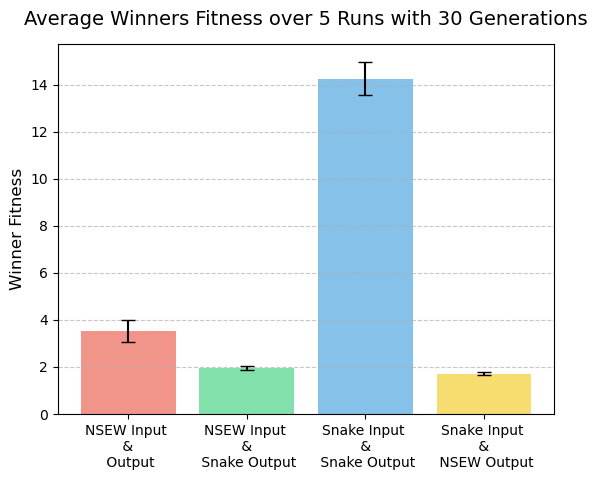

In [13]:
# Calculate the average fitness and standard deviation of the WINNERS ONLY over all runs
best_fitness_V3 = np.mean([g.fitness for g in SnakeV3_winners])
best_std_V3 = np.std([g.fitness for g in SnakeV3_winners])

# Data to plot
fitness_means = [best_fitness_V0, best_fitness_V1, best_fitness_V2, best_fitness_V3]
fitness_stds = [best_std_V0, best_std_V1, best_std_V2, best_std_V3]
labels = ['NSEW Input \n & \n Output', 'NSEW Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output', 'Snake Input \n & \n NSEW Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#f1948a', '#82e0aa', '#85c1e9', '#f7dc6f'])
ax.set_ylabel('Winner Fitness', fontsize=12)
ax.set_title(f'Average Winners Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations', fontsize=14, y = 1.03)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Dummy Inputs and Outputs

We can see this works much better. However, the snake does learn faster, but it does not learn better [You can check this yourself by setting the amount of generations higher, try ~200 generations for SnakeV0 and 300 for SnakeV1, if you have the time for such shenanigans].

There is now an open question: why does the network perform better when the inputs are in the new frame of reference? Is it simply because the network cannot run into itself anymore, or is it because the network is smaller, and thus easier to evolve? We can test this by using the new frame of reference but by adding a set of dummy inputs and outputs, to have the same network size as in the baseline model.  

We can do this by either using constant dummy inputs, or having them be drawn from a uniform distribution between 0 and 1. We will check for both cases.

#### Constant Dummy Inputs

In [14]:
if use_obstacles:
    input_features = ['relative_wall', 'relative_body','relative_apple', 'relative_obstacle']
else:
    input_features = ['relative_wall', 'relative_body','relative_apple']
    
SnakeV4A = SnakeGame(input_features= input_features,
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          min_time_to_eat_apple= 50,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10,
                          use_dummy_inputs= True)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV4A.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV4A.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm
SnakeV4A_stats = SnakeV4A.run_NEAT_repeated(neat_config_path)
SnakeV4A_winners = [stats.best_genome() for stats in SnakeV4A_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV4A_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV4A_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV4A_winners', SnakeV4A_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV4A_stats', SnakeV4A_stats)

{'num_inputs': '16', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9
Saving checkpoint to checkpoints//run0/population-19
Saving checkpoint to checkpoints//run0/population-29
Run 0 completed, best fitness: 10.3
Running NEAT algorithm, run 1
Saving checkpoint to checkpoints//run1/population-9
Saving checkpoint to checkpoints//run1/population-19
Saving checkpoint to checkpoints//run1/population-29
Run 1 completed, best fitness: 8.9
Running NEAT algorithm, run 2
Saving checkpoint to checkpoints//run2/population-9
Saving checkpoint to checkpoints//run2/population-19
Saving checkpoint to checkpoints//run2/population-29
Run 2 completed, best fitness: 11.3
Running NEAT algorithm, run 3
Saving checkpoint to checkpoints//run3/population-9
Saving checkpoint to checkpoints//run3/population-19
Saving checkpoint to checkpoints//run3/population-29
Run 3 completed, best fitness: 10.7
Running NEAT algorithm, run 4
Saving checkpoint to checkpoints//

In [15]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV4A_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV4A.test_winner(genome_1, neat_config_path)
# SnakeV4A.test_winner(genome_2, neat_config_path)

#### Uniformly Drawn Dummy Inputs

In [16]:
SnakeV4B = SnakeGame(input_features= input_features,
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          min_time_to_eat_apple= 50,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10,
                          use_dummy_inputs= True,
                          use_uniform_dummies= True)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV4B.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV4B.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm
SnakeV4B_stats = SnakeV4B.run_NEAT_repeated(neat_config_path)
SnakeV4B_winners = [stats.best_genome() for stats in SnakeV4B_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV4B_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV4B_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV4B_winners', SnakeV4B_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV4B_stats', SnakeV4B_stats)

{'num_inputs': '16', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9
Saving checkpoint to checkpoints//run0/population-19
Saving checkpoint to checkpoints//run0/population-29
Run 0 completed, best fitness: 11.3
Running NEAT algorithm, run 1
Saving checkpoint to checkpoints//run1/population-9
Saving checkpoint to checkpoints//run1/population-19
Saving checkpoint to checkpoints//run1/population-29
Run 1 completed, best fitness: 10.7
Running NEAT algorithm, run 2
Saving checkpoint to checkpoints//run2/population-9
Saving checkpoint to checkpoints//run2/population-19
Saving checkpoint to checkpoints//run2/population-29
Run 2 completed, best fitness: 9.1
Running NEAT algorithm, run 3
Saving checkpoint to checkpoints//run3/population-9
Saving checkpoint to checkpoints//run3/population-19
Saving checkpoint to checkpoints//run3/population-29
Run 3 completed, best fitness: 11.0
Running NEAT algorithm, run 4
Saving checkpoint to checkpoints//

In [17]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV4B_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV4B.test_winner(genome_1, neat_config_path)
# SnakeV4B.test_winner(genome_2, neat_config_path)

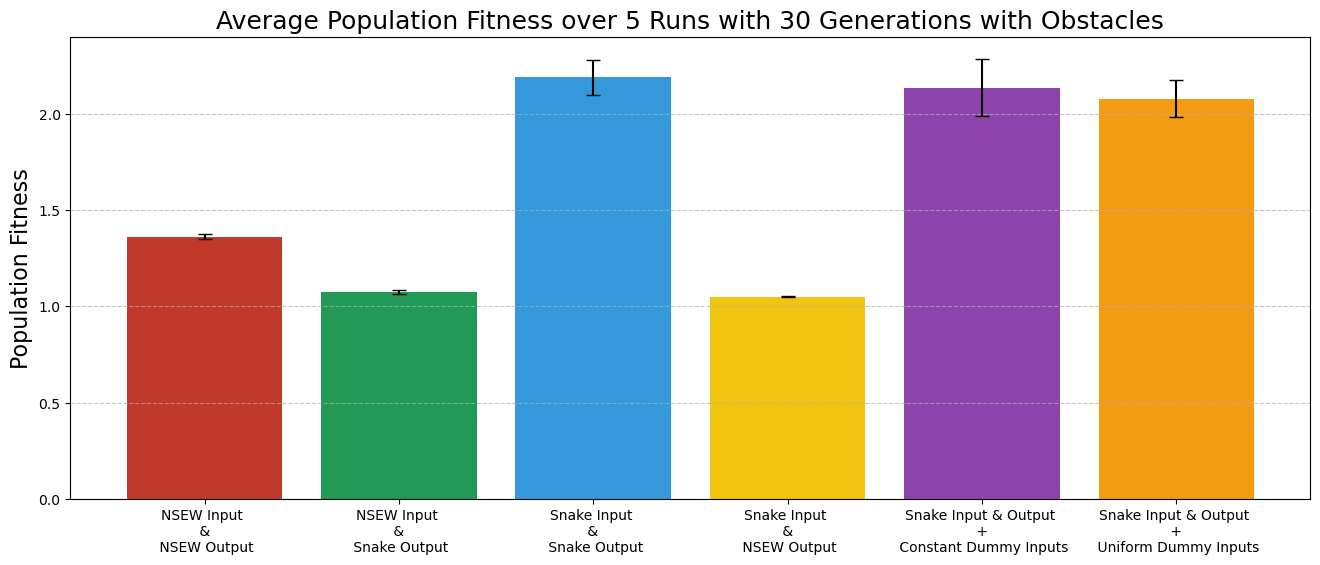

In [18]:
# Calculate average fitness and standard deviation of the WHOLE POPULATION over all runs
average_fitness_V4A= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV4A_stats])
std_fitness_V4A = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV4A_stats])

average_fitness_V4B= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV4B_stats])
std_fitness_V4B = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV4B_stats])

# Data to plot
fitness_means = [average_fitness_V0, average_fitness_V1, average_fitness_V2, average_fitness_V3,average_fitness_V4A, average_fitness_V4B]
fitness_stds = [std_fitness_V0, std_fitness_V1, std_fitness_V2, std_fitness_V3, std_fitness_V4A, std_fitness_V4B]
labels = ['NSEW Input \n & \n NSEW Output', 'NSEW Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output', 'Snake Input \n & \n NSEW Output', 'Snake Input & Output \n + \n Constant Dummy Inputs', 'Snake Input & Output \n + \n Uniform Dummy Inputs']

# Creating big final bar plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954', '#3498db', '#f1c40f', '#8e44ad', '#f39c12'])
ax.set_ylabel('Population Fitness', size=16)
if use_obstacles:
    ax.set_title(f'Average Population Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations with Obstacles', fontsize=18)
else:
    ax.set_title(f'Average Population Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations without Obstacles', fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
if use_obstacles:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/Frame_Of_Reference_With_Obstacles_Experiment_Average.png')
else:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/Frame_Of_Reference_Without_Obstacles_Experiment_Average.png')
plt.show()

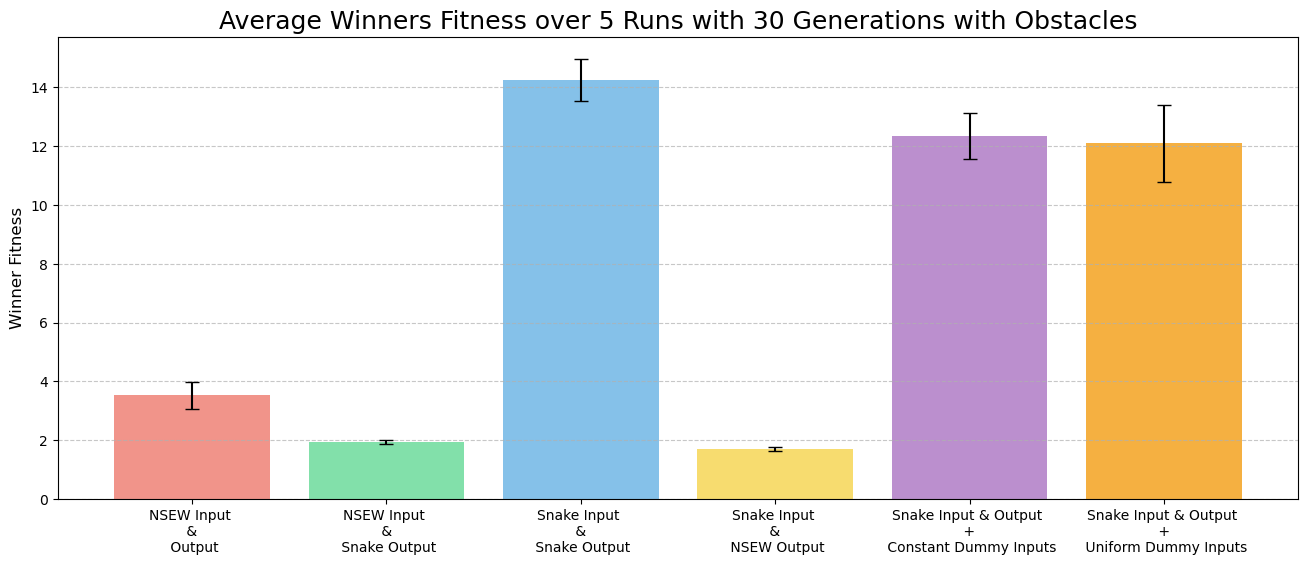

In [19]:
# Calculate the average fitness and standard deviation of the WINNERS ONLY over all runs
best_fitness_V4A = np.mean([g.fitness for g in SnakeV4A_winners])
best_std_V4A = np.std([g.fitness for g in SnakeV4A_winners])

best_fitness_V4B = np.mean([g.fitness for g in SnakeV4B_winners])
best_std_V4B = np.std([g.fitness for g in SnakeV4B_winners])

# Data to plot
fitness_means = [best_fitness_V0, best_fitness_V1, best_fitness_V2, best_fitness_V3, best_fitness_V4A, best_fitness_V4B]
fitness_stds = [best_std_V0, best_std_V1, best_std_V2, best_std_V3, best_std_V4A, best_std_V4B]
labels = ['NSEW Input \n & \n Output', 'NSEW Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output', 'Snake Input \n & \n NSEW Output', 'Snake Input & Output \n + \n Constant Dummy Inputs', 'Snake Input & Output \n + \n Uniform Dummy Inputs']

# Creating big final bar plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#f1948a', '#82e0aa', '#85c1e9', '#f7dc6f', '#bb8fce', '#f5b041'])
ax.set_ylabel('Winner Fitness', fontsize=12)
if use_obstacles:
    ax.set_title(f'Average Winners Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations with Obstacles', fontsize=18)
else:
    ax.set_title(f'Average Winners Fitness over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations without Obstacles', fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
if use_obstacles:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/Frame_Of_Reference_With_Obstacles_Experiment_Winner.png')
else:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/Frame_Of_Reference_Without_Obstacles_Experiment_Winner.png')
plt.show()

**It appears that the network with constant dummy inputs performs the best. This is somewhat surprising as it should be easier to evolve a smaller network for NEAT. However, it is possible that the parameters of the NEAT algorithm are optimized for the network of this size. While not done here, one could also optimize the parameters of the NEAT algorithm for the other network sizes. From here on, we keep working with the best version: The snake input & output with constant dummy inputs**

## Experiment 2: Binary Inputs
Up till now, we used relative distances in our feature space. Where we only denote whether a body part, obstacle or fruit is present in a certain direction. Since the wall is always present, we encode it as being 1 only if the snake head is directly next to the wall in said direction, and 0 otherwise. We will check for performance with binary inputs, one with relative wall distances and one with binary wall information.

The motivation behind doing these two versions, is that the Snake does perhaps not need to know the exact distance to obstacles or apples, but it can indirectly infer its location on the grid from its distance to the walls, which might be important information. 

In [20]:
if use_obstacles:
    binary_input_features = ['binary_wall', 'binary_body','binary_apple', 'binary_obstacle']
else:
    binary_input_features = ['binary_wall', 'binary_body','binary_apple']

SnakeV5A = SnakeGame(input_features= binary_input_features,
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10,
                          use_dummy_inputs= True)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV5A.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV5A.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm
SnakeV5A_stats = SnakeV5A.run_NEAT_repeated(neat_config_path)
SnakeV5A_winners = [stats.best_genome() for stats in SnakeV5A_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV5A_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV5A_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV5A_winners', SnakeV5A_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV5A_stats', SnakeV5A_stats)

{'num_inputs': '16', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9
Saving checkpoint to checkpoints//run0/population-19
Saving checkpoint to checkpoints//run0/population-29
Run 0 completed, best fitness: 14.4
Running NEAT algorithm, run 1
Saving checkpoint to checkpoints//run1/population-9
Saving checkpoint to checkpoints//run1/population-19
Saving checkpoint to checkpoints//run1/population-29
Run 1 completed, best fitness: 16.5
Running NEAT algorithm, run 2
Saving checkpoint to checkpoints//run2/population-9
Saving checkpoint to checkpoints//run2/population-19
Saving checkpoint to checkpoints//run2/population-29
Run 2 completed, best fitness: 17.0
Running NEAT algorithm, run 3
Saving checkpoint to checkpoints//run3/population-9
Saving checkpoint to checkpoints//run3/population-19
Saving checkpoint to checkpoints//run3/population-29
Run 3 completed, best fitness: 13.9
Running NEAT algorithm, run 4
Saving checkpoint to checkpoints/

In [21]:
if use_obstacles:
    binary_input_features = ['relative_wall', 'binary_body','binary_apple', 'binary_obstacle']
else:
    binary_input_features = ['relative_wall', 'binary_body','binary_apple']


SnakeV5B = SnakeGame(input_features= binary_input_features,
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10,
                          use_dummy_inputs= True)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV5B.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV5B.neat_params['input_output']['DefaultGenome'])


#Run the NEAT algorithm
SnakeV5B_stats = SnakeV5B.run_NEAT_repeated(neat_config_path)
SnakeV5B_winners = [stats.best_genome() for stats in SnakeV5B_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV5B_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV5B_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV5B_winners', SnakeV5B_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV5B_stats', SnakeV5B_stats)

{'num_inputs': '16', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to checkpoints//run0/population-9


In [ ]:
# Calculate average fitness and standard deviation of the WHOLE POPULATION over all runs
average_fitness_V5A= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV5A_stats])
std_fitness_V5A = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV5A_stats])

average_fitness_V5B = np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV5B_stats])
std_fitness_V5B = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV5B_stats]) 

# Data to plot
fitness_means = [average_fitness_V4A, average_fitness_V5A, average_fitness_V5B]
fitness_stds = [std_fitness_V4A, std_fitness_V5A, std_fitness_V5B]
labels = ['Relative Inputs', 'Binary Inputs \n & \n Binary Wall', 'Binary Inputs \n & \n Relative Wall']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=[ '#7d2dbe', '#be2db7', '#be2d6f'])
ax.set_ylabel('Population Fitness', fontsize=12)
if use_obstacles:
    ax.set_title(f'Average Population Fitness over {SnakeV5A.N_RUNS} Runs with {SnakeV5A.N_GENERATIONS} \n Generations for Snake Input & Output with Obstacles', size=14, y = 1.03)
else:
    ax.set_title(f'Average Population Fitness over {SnakeV5A.N_RUNS} Runs with {SnakeV5A.N_GENERATIONS} \n Generations for Snake Input & Output without Obstacles', size=14, y = 1.03)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/Binary_Features_Experiment.png')
plt.show()

In [ ]:
#Calculate the average fitness and standard deviation of the WINNERS ONLY over all runs
best_fitness_V5A = np.mean([g.fitness for g in SnakeV5A_winners])
best_std_V5A = np.std([g.fitness for g in SnakeV5A_winners])

best_fitness_V5B = np.mean([g.fitness for g in SnakeV5B_winners])
best_std_V5B = np.std([g.fitness for g in SnakeV5B_winners])

# Data to plot
fitness_means = [best_fitness_V4A, best_fitness_V5A, best_fitness_V5B]
fitness_stds = [best_std_V4A, best_std_V5A, best_std_V5B]
labels = ['Relative Inputs', 'Binary Inputs \n & \n Binary Wall', 'Binary Inputs \n & \n Relative Wall']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=[ '#c371f7', '#f771e8', '#f771a5'])
ax.set_ylabel('Winner Fitness', fontsize=12)
if use_obstacles:
    ax.set_title(f'Average Winners Fitness over {SnakeV5A.N_RUNS} Runs \n with {SnakeV5A.N_GENERATIONS} Generations for Snake Input & Output and Obstacles', size=14, y = 1.03)
else:    
    ax.set_title(f'Average Winners Fitness over {SnakeV5A.N_RUNS} Runs \n with {SnakeV5A.N_GENERATIONS} Generations for Snake Input & Output without Obstacles', size=14, y = 1.03)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Simulate behaviour of the (full) binary snake

In [ ]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV5A_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]
update_config('config-neat','DefaultGenome', SnakeV5A.neat_params['input_output']['DefaultGenome'])

#uncomment one to test either genome_1 or genome_2
# SnakeV5A.test_winner(genome_1, neat_config_path)
SnakeV5A.test_winner(genome_2, neat_config_path)

**It appears that binary encodings perform better than relative distances. At first, this might be somewhat surprising, as the relative distances should contain more information. However, if we look at the actual strategy the snake learns, it is clear that it only needs binary inputs to perform this strayegy. As to why the other network does not learn a 'better' strategy, it is possible that the network is not able to learn the transformation from the relative distances to the binary encodings. From now on we will**

# Experiment 3: Obstacles
Now we've determined the right frame of reference for our inputs and outputs, we can make it a bit more challenging for the snake. You might have noticed that right now the snake adopts a very simple strategy: it always trails along the wall until it lines up with the apple, and then goes straight for it. We can make it a bit more challenging by adding obstacles to the game. To make it a fair competition, we will give the snake information on the position of this obstacle, by adding the input feature `distance_to_obstacle`. Let's evolve it for only one run for a bit more generations, say 100.

In [ ]:
SnakeV6 = SnakeGame(input_features= ['binary_wall', 'binary_body','binary_apple', 'binary_obstacle'],
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= True,
                          n_runs = 1,
                          n_generations = 100,
                          time_interval= 200,
                          checkpoint_interval= 10,
                          use_dummy_inputs= True)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV6.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV6.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV1
SnakeV6_stats= SnakeV6.run_NEAT_repeated(neat_config_path)
SnakeV6_winners = [stats.best_genome() for stats in SnakeV6_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV6_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV6_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV6_winners', SnakeV6_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV6_stats', SnakeV6_stats)

In [ ]:
#Get statistics from the best run
generations = range(1, SnakeV6.N_GENERATIONS + 1)
winner_stats = SnakeV6_stats[best_run_idx]
best_fitnesses = [g.fitness for g in winner_stats.most_fit_genomes]
avg_fitnesses = np.array(winner_stats.get_fitness_mean())
stdev_fitnesses = np.array(winner_stats.get_fitness_stdev())

# Plot the best run statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get statistics from all runs
best_genomes = [[g for g in stats.most_fit_genomes] for stats in SnakeV6_stats]

# Plot the best genome of each run
for i, genome in enumerate(best_genomes):
    fitnesses = [g.fitness for g in genome]
    ax1.plot(generations, fitnesses, label=f"Run {i + 1}")

ax1.set_title("Evolution of Best Genome for each Run")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness")
ax1.grid()
ax1.legend(loc="best")

ax2.plot(generations, best_fitnesses, color='#c0392b', label="Best Genome")
ax2.plot(generations, avg_fitnesses, color='#229954', label="Average")
ax2.plot(generations, avg_fitnesses + stdev_fitnesses, color='#abebc6', label="+1 $\sigma_{std}$")
ax2.plot(generations, avg_fitnesses - stdev_fitnesses, color='#abebc6', label="-1 $\sigma_{std}$")

ax2.set_title(f"Fitness over Generations of Best Run ({best_run_idx + 1})")
ax2.set_xlabel("Generations")
ax2.set_ylabel("Fitness")
ax2.grid()
ax2.legend(loc="best")

plt.show()

### Check performance in a simulation
Does the snake learn to avoid the obstacles? Let's check the performance of the best genome at generation 50 and 100.

In [ ]:
generation_nr_1 = 50
generation_nr_2 = -1

# Get the best genome at every generation
best_genomes = [g for g in SnakeV6_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV6.test_winner(genome_1, neat_config_path)
SnakeV6.test_winner(genome_2, neat_config_path)

## Experiment 4: Constrained Environment
To check for adaptation in environmental constraints, we can lower the time the snake has to eat the apple. This will make the game harder, as the snake has to learn to eat the apple faster. We will check from multiple values of `time_to_eat_apple` to see how the snake adapts.

In [ ]:
if use_obstacles:
    binary_input_features = ['binary_wall', 'binary_body','binary_apple', 'binary_obstacle']
else:
    binary_input_features = ['binary_wall', 'binary_body','binary_apple']

# Data to plot
fitness_means_contrained = []
fitness_stds_constrained = []
winners_means_constrained = []
winners_stds_constrained = []
times_to_eat_apple = [20, 30, 40, 50]

for i, time in enumerate(times_to_eat_apple):
    SnakeConstrainted = SnakeGame(input_features= binary_input_features,
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= use_obstacles,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10,
                          use_dummy_inputs= True,
                          min_time_to_eat_apple= time,)

    #Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
    print(SnakeConstrainted.neat_params['input_output']['DefaultGenome'])
    update_config('config-neat','DefaultGenome', SnakeConstrainted.neat_params['input_output']['DefaultGenome'])

    #Run the NEAT algorithm on the Snake
    SnakeConstrainted_stats= SnakeConstrainted.run_NEAT_repeated(neat_config_path)
    SnakeConstrainted_winners = [stats.best_genome() for stats in SnakeConstrainted_stats]
    best_run_idx = np.argmax([winner.fitness for winner in SnakeConstrainted_winners])
    print(f"Best run: {best_run_idx} with fitness:§ {SnakeConstrainted_winners[best_run_idx].fitness} for time_to_eat_apple = {time}")

    # Calculate average fitness and standard deviation of the WHOLE POPULATION over all runs
    average_fitness= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeConstrainted_stats])
    std_fitness = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeConstrainted_stats])

    # Calculate average fitness and standard deviation of the WINNERS ONLY over all runs
    best_fitness = np.mean([g.fitness for g in SnakeConstrainted_winners])
    best_std = np.std([g.fitness for g in SnakeConstrainted_winners])

    # Store the results
    fitness_means_contrained.append(average_fitness)
    fitness_stds_constrained.append(std_fitness)
    winners_means_constrained.append(best_fitness)
    winners_stds_constrained.append(best_std)

In [ ]:
# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(times_to_eat_apple, fitness_means_contrained, yerr=fitness_stds_constrained, capsize=5, color=['#ec3f6a','#ec6a3f', '#ecc13f', '#c1ec3f'], width=7)
ax.set_ylabel('Average Fitness')
ax.set_xlabel('Time to Eat Apple (Timesteps))')
ax.set_xticks(np.arange(20, 60, 10))

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)
if use_obstacles:
    ax.set_title(f'Average Fitness for different Apple Eat Times \n over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations with Obstacles')
else:
    ax.set_title(f'Average Fitness for different Apple Eat Times Sizes \n over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations without Obstacles')

# Show the plot
if use_obstacles:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/constrained_environment_with_obstacles.png')
else:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/constrained_environment_without_obstacles.png')

plt.show()

## Investigation 5: Memory
It should be possible to make the snake have 'zigzag' behaviour by adding a memory feature. This way, the snake can remember the last direction it took, and avoid running into itself. We implemented this feature by encoding the direction the snake took as a number between 0 and 1 (0.33 = turned left, 0.66, turned right and 1 = went straight). It is possible to make the snake remember up to 'history_length' steps. We will check for performance with different values of 'history_length'.

In [ ]:
# Data to plot
fitness_means_memory = []
fitness_stds_memory = []
history_lengths = [1, 5, 9]

for history_length in history_lengths:
    SnakeMemory = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple', 'history'],
                            input_frame_of_reference= 'SNAKE', 
                            output_frame_of_reference= 'SNAKE',
                            history_length = history_length,
                            use_obstacles= use_obstacles,
                            n_runs = 5,
                            n_generations = 30,
                            time_interval= 200,
                            use_dummy_inputs= False #Dummy inputs are not compatible with move history in this version.
                            checkpoint_interval= 10)

    #Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
    print(SnakeMemory.neat_params['input_output']['DefaultGenome'])
    update_config('config-neat','DefaultGenome', SnakeMemory.neat_params['input_output']['DefaultGenome'])

    #Run the NEAT algorithm on the Snake
    SnakeMemory_stats = SnakeMemory.run_NEAT_repeated(neat_config_path)
    SnakeMemory_winners = [stats.best_genome() for stats in SnakeMemory_stats]
    best_run_idx = np.argmax([winner.fitness for winner in SnakeMemory_winners])
    print(f"Best run: {best_run_idx} with fitness:§ {SnakeMemory_winners[best_run_idx].fitness}")

    # Calculate average fitness and standard deviation of the WHOLE POPULATION over all runs
    average_fitness= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeMemory_stats])
    std_fitness = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeMemory_stats])

    # Store the results
    fitness_means_memory.append(average_fitness)
    fitness_stds_memory.append(std_fitness)

### Check performance in a simulation

In [ ]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeMemory_stats[best_run_idx].most_fit_genomes]

# genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeMemory.test_winner(genome_1, neat_config_path)
SnakeMemory.test_winner(genome_2, neat_config_path)

In [ ]:
# Creating the bar plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(history_lengths, fitness_means_memory, yerr=fitness_stds_memory, capsize=5, color=['#3fec6f', '#3fecc5', '#3fbcec'], width = 2)
ax.set_ylabel('Average Fitness')
ax.set_xlavel('Memory Length')
if use_obstacles:
    ax.set_title(f'Average Fitness for different Memory Sizes \n over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations with Obstacles')
else:
    ax.set_title(f'Average Fitness for different Memory Sizes \n over {SnakeV0.N_RUNS} Runs with {SnakeV0.N_GENERATIONS} Generations without Obstacles')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
if use_obstacles:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/memory_with_obstacles.png')
else:
    plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/memory_without_obstacles.png')

plt.show()

**It appears that performance is not really improved, perhaps a smarter encoding of memory could do the trick**